In [74]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fitsio
import glob
import emcee
import scipy.optimize as sco

Autocorrelation function pinched from emcee

In [75]:
def acorr(x, axis=0):
    """
    Estimate the autocorrelation function of a time series using the FFT.
    :param x:
        The time series. If multidimensional, set the time axis using the
        ``axis`` keyword argument and the function will be computed for every
        other axis.
    """
    x = np.atleast_1d(x)
    m = [slice(None), ] * len(x.shape)

    # For computational efficiency, crop the chain to the largest power of
    # two if requested.
    n = x.shape[axis]

    # Compute the FFT and then (from that) the auto-correlation function.
    f = np.fft.fft(x-np.mean(x, axis=axis), n=2*n, axis=axis)
    m[axis] = slice(0, n)
    acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
    m[axis] = 0
    return acf / acf[m]

A Squared exponential function

In [76]:
def SE(par, x):
    return par[0] * np.exp(-x**2/(2*par[1]**2))

A QP function

In [85]:
def QP(par, x):
    return par[0] * np.exp( - x**2/(2*par[1]**2) - par[2]**2 * (np.sin(np.pi*x/par[3]))**2 )

A Cosine exponential function

In [114]:
def C(par, x):
    return par[0] * np.exp( - x**2/(2*par[1]**2)) + par[2] * np.cos(2*np.pi*x/par[3])

Load and plot an example light curve

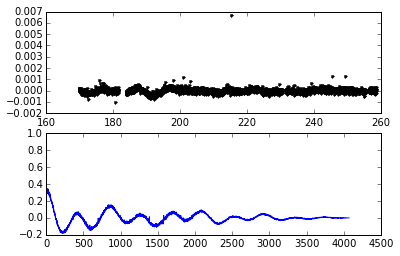

In [109]:
kid = "008311864"
fnames = glob.glob("/Users/ruthangus/.kplr/data/lightcurves/{0}/*".format(kid))
data = fitsio.read(fnames[2])
time = data["TIME"]
flux = data["PDCSAP_FLUX"]
err = data["PDCSAP_FLUX_ERR"]
m = np.isfinite(time) * np.isfinite(flux) * np.isfinite(err)
x = time[m]
med = np.median(flux[m])
y = flux[m]/med - 1
yerr = err[m]/med
plt.subplot(2, 1, 1)
plt.plot(x, y, "k.")
plt.subplot(2, 1, 2)
acf = acorr(y)
plt.plot(acf) # plot acf

Plot the covariance functions

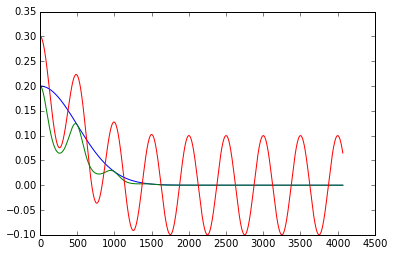

In [118]:
A, l, g, P, a2 = .2, 500, 1, 500, .1
xs = np.arange(len(acf))
se = SE([A, l], xs)
qp = QP([A, l, g, P], xs)
cos = C([A, l, a2, P], xs)
plt.plot(se)
plt.plot(qp)
plt.plot(cos)

Fit the two functions to the ACF

Negative log likelihood

In [119]:
import scipy.misc as spm

def SE_NLL(par, x, y):
    m = SE(par, x)
    return .5 * spm.logsumexp((y-m)**2)
    #return .5 * (np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def QP_NLL(par, x, y):
    m = QP(par, x)
    return .5 * spm.logsumexp((y-m)**2)

def C_NLL(par, x, y):
    m = C(par, x)
    return .5 * spm.logsumexp((y-m)**2)

Fit the QP Kernel

In [120]:
QP_init = [A, l, g, P]
QPresult = sco.minimize(QP_NLL, QP_init, args=(xs, acf))
QP_results = QPresult.x
print(QP_results)

[  2.13462214e-01   4.99998216e+02   2.44948896e+00   4.99994580e+02]


Fit the SE Kernel

In [121]:
SE_init = [A, l]
SEresult = sco.minimize(SE_NLL, SE_init, args=(xs, acf))
SE_results = SEresult.x
print(SE_results)

[  1.27721261e-02   4.99999964e+02]


Fit the cosine results

In [122]:
C_init = [A, l, a2, P]
Cresult = sco.minimize(C_NLL, C_init, args=(xs, acf))
C_results = Cresult.x
print(C_results)

[  1.22650070e-02   4.99999966e+02   1.55570058e-02   4.99999978e+02]


Plot the results

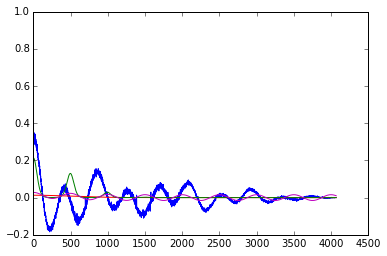

In [123]:
A_qp, l_qp, g, P = QP_results
A_se, l_se = SE_results
A_c, l_c, a2_c, P_c = C_results
plt.plot(acf) # plot acf
plt.plot(SE([A_se, l_se], xs), color="r")
plt.plot(QP([A_qp, l_qp, g, P], xs), color="g")
plt.plot(C([A_c, l_c, a2_c, P_c], xs), color="m")

Generate samples, then fit their acfs!

In [130]:
import george
from george.kernels import ExpSquaredKernel, ExpSine2Kernel, CosineKernel

SE kernel first

0.2 500


/Users/ruthangus/anaconda/lib/python3.5/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


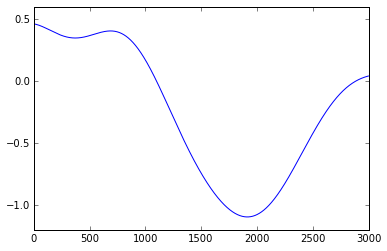

In [125]:
K = A * ExpSquaredKernel(l**2)
gp = george.GP(K)
xs = np.arange(3000)
sample = gp.sample(xs, 1)
plt.plot(sample)
print(A, l)

Calculate its ACF and fit an SE function

[   1.04626163  334.55410493]


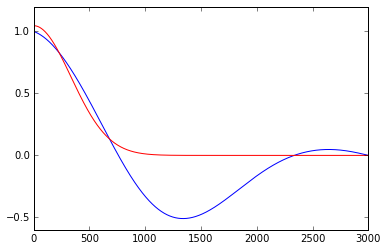

In [126]:
acf = acorr(sample)
SE_init = [A, l]
SEresult = sco.minimize(SE_NLL, SE_init, args=(xs, acf))
SE_results = SEresult.x
print(SE_results)
A_se, l_se = SE_results
plt.plot(acf) # plot acf
plt.plot(SE([A_se, l_se], xs), color="r")

Then a QP kernel

0.2 500 2.44948895915 499.994579769


/Users/ruthangus/anaconda/lib/python3.5/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


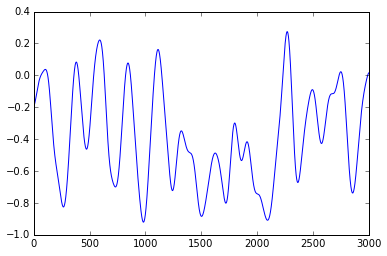

In [135]:
K = A * ExpSquaredKernel(l**2) * ExpSine2Kernel(g, P)
gp = george.GP(K)
xs = np.arange(3000)
sample = gp.sample(xs, 1)
plt.plot(sample)
print(A, l, g, P)

[   0.88443283  499.99451188    3.39738188  499.99772649]


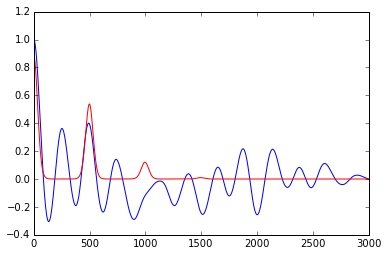

In [136]:
acf = acorr(sample)
QP_init = [A, l, g, P]
QPresult = sco.minimize(QP_NLL, QP_init, args=(xs, acf))
QP_results = QPresult.x
print(QP_results)
A_qp, l_qp, g_qp, P_qp = QP_results
plt.plot(acf) # plot acf
plt.plot(QP([A_qp, l_qp, g_qp, P_qp], xs), color="r")

[  1.58026380e-01   4.99999925e+02   1.65922510e-02   4.99994674e+02]


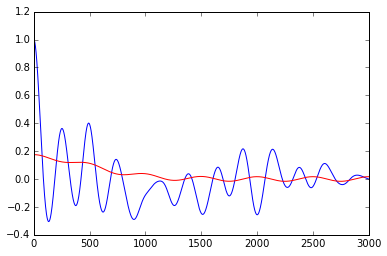

In [137]:
C_init = [A, l, a2, P]
Cresult = sco.minimize(C_NLL, C_init, args=(xs, acf))
C_results = Cresult.x
print(C_results)
A_c, l_c, a2_c, P_c = C_results
plt.plot(acf) # plot acf
plt.plot(C([A_c, l_c, a2_c, P_c], xs), color="r")

Then a cosine kernel

0.2 500 0.1 499.994579769


/Users/ruthangus/anaconda/lib/python3.5/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


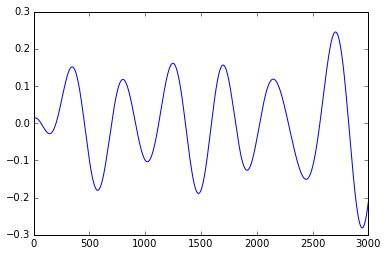

In [132]:
K = A * ExpSquaredKernel(l**2) * a2 * CosineKernel(P)
gp = george.GP(K)
xs = np.arange(3000)
sample = gp.sample(xs, 1)
plt.plot(sample)
print(A, l, a2, P)

[  1.57893049e-02   4.99996846e+02   3.88862600e-01   4.72199978e+02]


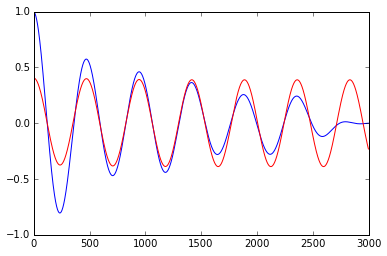

In [133]:
acf = acorr(sample)
C_init = [A, l, a2, P]
Cresult = sco.minimize(C_NLL, C_init, args=(xs, acf))
C_results = Cresult.x
print(C_results)
A_c, l_c, a2_c, P_c = C_results
plt.plot(acf) # plot acf
plt.plot(C([A_c, l_c, a2_c, P_c], xs), color="r")